In [1]:
# %%
from omegaconf import DictConfig
import hydra, torch, numpy as np
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from cellot.models.cond_score_module import CondScoreModule, CondScoreModuleV2
from cellot.data.sciplex_ae_dm import CellDataModule
from cellot.data.utils import load_ae_cell_data, load_ae, cast_dataset_to_loader
from cellot.train.utils import get_free_gpu
from cellot.utils.dev_utils import load_markers, compute_mmd_loss, get_ckpt_path_from_artifact_id, get_target_cond_idx
from tqdm import tqdm

gammas = np.logspace(1, -3, num=50)

def inference(lm, batch, lamb=4, dt=0.01, t_start=1.0, cond=True, ae=None, target=None):
    device = lm.device
    assert ae is not None, 'Must provide autoencoder'
    assert target is not None or not cond, 'Must provide target'
    
    with torch.inference_mode():
        lm.eval()
        all_genes_x, y_batch = batch
        
        if cond:
            y = torch.ones_like(y_batch) * get_target_cond_idx(target)
        else:
            y = y_batch
        
        y = y.to(device)
        
        latent_x = ae.eval().encode(all_genes_x)
        latent_iden_recon = ae.eval().decode(latent_x)
        
        x_t, _ = lm.diffuser.forward_marginal(latent_x.detach().cpu().numpy(), t=t_start)
        
        for i, t in enumerate(np.arange(t_start, 0, -dt)):
            x_t = torch.tensor(x_t).float().to(device)
            uncond_score = lm.score_network((x_t, (torch.ones_like(y) * lm.score_network.null_cond_idx).to(device)), t)
            if cond:
                cond_score = lm.score_network((x_t, y), t)
                pred_score = (1 + lamb) * cond_score - lamb * uncond_score
            else:
                pred_score = uncond_score
            
            x_t = lm.diffuser.reverse(x_t=x_t.detach().cpu().numpy(), score_t=pred_score.detach().cpu().numpy(), t=t, dt=lm.dt, center=False)
        
        x_0 = torch.tensor(x_t, dtype=torch.float).to(lm.device)
        
        recon = ae.eval().decode(x_0)
        return recon, latent_x, x_0, latent_iden_recon


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
  File "/tmp/ipykernel_3201062/3886228366.py", line 2, in <module>
    from omegaconf import DictConfig
  File "/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/omegaconf/__init__.py", line 1, in <module>
    from .base import Container, DictKeyType, Node, SCMode, UnionNode
  File "/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/omegaconf/base.py", line 11, in <module>
    from ._utils import (
  File "/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/omegaconf/_utils.py", line 112, in <module>
    class OmegaConfDumper(yaml.Dumper):  # type: ignore
AttributeError: module 'yaml' has no attribute 'Dumper'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/

In [2]:
import hydra
with hydra.initialize('../configs/diff/'):
    cfg = hydra.compose(config_name='eval.yaml')

/tmp/ipykernel_3189564/2865889496.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize('../configs/diff/'):
/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'eval.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [3]:
cfg.TARGET = 'abexinostat'

In [4]:
replica_id = int(get_free_gpu())
device = f'cuda:{replica_id}'

if cfg.MODEL_CLASS == 'CondScoreModule':
    model_class = CondScoreModule
elif cfg.MODEL_CLASS == 'CondScoreModuleV2':
    model_class = CondScoreModuleV2

if cfg.WARM_START:
    model = model_class.load_from_checkpoint(checkpoint_path=cfg.WARM_START_PATH, hparams=cfg)
    cfg.experiment.wandb_logger.name = cfg.experiment.wandb_logger.name + '_WS'

else:
    model = model_class(cfg)
    
model = model.to(device)
autoencoder = load_ae(cfg, device='cpu', restore=cfg.AE_PATH, input_dim=1000).to(device)

datasets = load_ae_cell_data(cfg, return_as='dataset', split_on=["split", "transport"])
loader = cast_dataset_to_loader(datasets, batch_size=cfg.dataloader.batch_size, shuffle=False, drop_last=False)


cuda
Using GPUs: 1
Dropout is 0.1
Loading ae from checkpoint


In [5]:
# source = datasets.test.source.adata.X
target = datasets.test.target.adata.X

gts = []
recons = []
uncond_recons = []
mmds = []
latent_identities = []
lxs = []
x_0s = []

lamb = cfg.infer.lamb
dt = cfg.infer.dt
t_start = cfg.infer.t_start
cond = cfg.infer.cond

for batch in tqdm(loader.test.source):
    batch = [x.to(device) for x in batch]
    gts.append(batch)
    recon, latent_x, x_0, latent_iden_recon = inference(model, batch, ae=autoencoder, lamb=lamb, dt=dt, t_start=t_start, cond=cond, target=cfg.TARGET)
    uncond_recon, _, _, _ = inference(model, batch, ae=autoencoder, lamb=lamb, dt=dt, t_start=t_start, cond=False, target=cfg.TARGET)
    
    recons.append(recon)
    uncond_recons.append(uncond_recon)
    lxs.append(latent_x)
    x_0s.append(x_0)
    latent_identities.append(latent_iden_recon)
    


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:48<00:00,  3.45s/it]


In [6]:
all_gts = torch.cat([x[0] for x in gts], dim=0)

In [7]:
import matplotlib.pyplot as plt

In [8]:
recon

tensor([[ 0.0225,  0.0066,  0.0038,  ...,  0.0029, -0.0014, -0.0096],
        [ 0.0242,  0.0117, -0.0108,  ...,  0.0045,  0.0278,  0.0071],
        [-0.0135,  0.0050,  0.0100,  ...,  0.0011, -0.0202, -0.0072],
        ...,
        [-0.0003, -0.0086,  0.0076,  ...,  0.0050, -0.0039,  0.0007],
        [ 0.0091,  0.0122,  0.0126,  ..., -0.0001, -0.0108, -0.0015],
        [ 0.1004, -0.0096, -0.0146,  ..., -0.0040,  0.0269,  0.0473]],
       device='cuda:1')

In [9]:
import pandas as pd
sorted_spearman_df = pd.read_csv('/Mounts/rbg-storage1/users/johnyang/cellot/notebooks/sorted_spearman.csv')

In [10]:
sorted_spearman_df.head()

,id,gene_short_name,n_cells,highly_variable,means,dispersions,dispersions_norm,spearmanr_recon
0,ENSG00000170921.15,TANC2,422727,True,2.582102,3.243572,1.904368,0.944853
1,ENSG00000185305.10,ARL15,403964,True,2.118916,3.087871,1.566747,0.925634
2,ENSG00000074410.13,CA12,311128,True,1.950621,3.101116,1.607566,0.874188
3,ENSG00000149485.18,FADS1,292092,True,1.679964,3.006801,1.939378,0.866289
4,ENSG00000251574.6,AC099520.1,286116,True,1.967979,3.457096,2.704655,0.863859


In [11]:
sorted_genes_ae = sorted_spearman_df['id']
good_ae_genes = set(sorted_genes_ae[:300])

In [27]:
from cellot.data.cell import read_single_anndata
def load_markers(config, n_genes=50, gene_pool=None):
    data = read_single_anndata(config, path=None)
    key = f'marker_genes-{config.data.condition}-rank'

    # rebuttal preprocessing stored marker genes using
    # a generic marker_genes-condition-rank key
    # instead of e.g. marker_genes-drug-rank
    # let's just patch that here:
    if key not in data.varm:
        key = 'marker_genes-condition-rank'
        print('WARNING: using generic condition marker genes')

    sel_mg = (
        data.varm[key][config.data.target]
        .sort_values()
        .index
    )[:n_genes]
    
    # Filter selected marker genes based on gene pool
    if gene_pool is not None:
        sel_mg = set(sel_mg).intersection(gene_pool)

    marker_gene_indices = [i for i, gene in enumerate(data.var_names) if gene in sel_mg]
    marker_gene_names = [gene for gene in data.var_names if gene in sel_mg]
    
    return sel_mg, marker_gene_indices, marker_gene_names


In [28]:
sel_mg, gene_idxs, gene_names = load_markers(cfg, gene_pool=good_ae_genes)

2023-07-12 14:43:12,996 Loaded cell data with TARGET abexinostat and OBS SHAPE (22070, 16)


In [15]:
n_markers = 50

In [16]:
all_recon = torch.cat(recons, dim=0)
all_lxs = torch.cat(lxs, dim=0)
all_x0s = torch.cat(x_0s, dim=0)    
all_uncond_recons = torch.cat(uncond_recons, dim=0)
all_latent_identities = torch.cat(latent_identities, dim=0)

sel_target = target[:, gene_idxs[:n_markers]]
sel_recon = all_recon[:, gene_idxs[:n_markers]].detach().cpu().numpy()
mmd_agg = compute_mmd_loss(sel_recon, sel_target, gammas)

sel_uncond_recon = all_uncond_recons[:, gene_idxs[:n_markers]].detach().cpu().numpy()
uncond_mmd_agg = compute_mmd_loss(sel_uncond_recon, sel_target, gammas)

# mean_mmd = np.mean(mmds)
print(f'MMD: {mmd_agg:.4f}') #TODO: Set up basic logging here.
print(f'Uncond MMD: {uncond_mmd_agg:.4f}')
# print(f'MMD: {mmd_agg:.4f}, Mean MMD: {mean_mmd:.4f}') #TODO: Set up basic logging here.


MMD: 0.0197
Uncond MMD: 0.0197


In [17]:
len(gene_idxs)

30

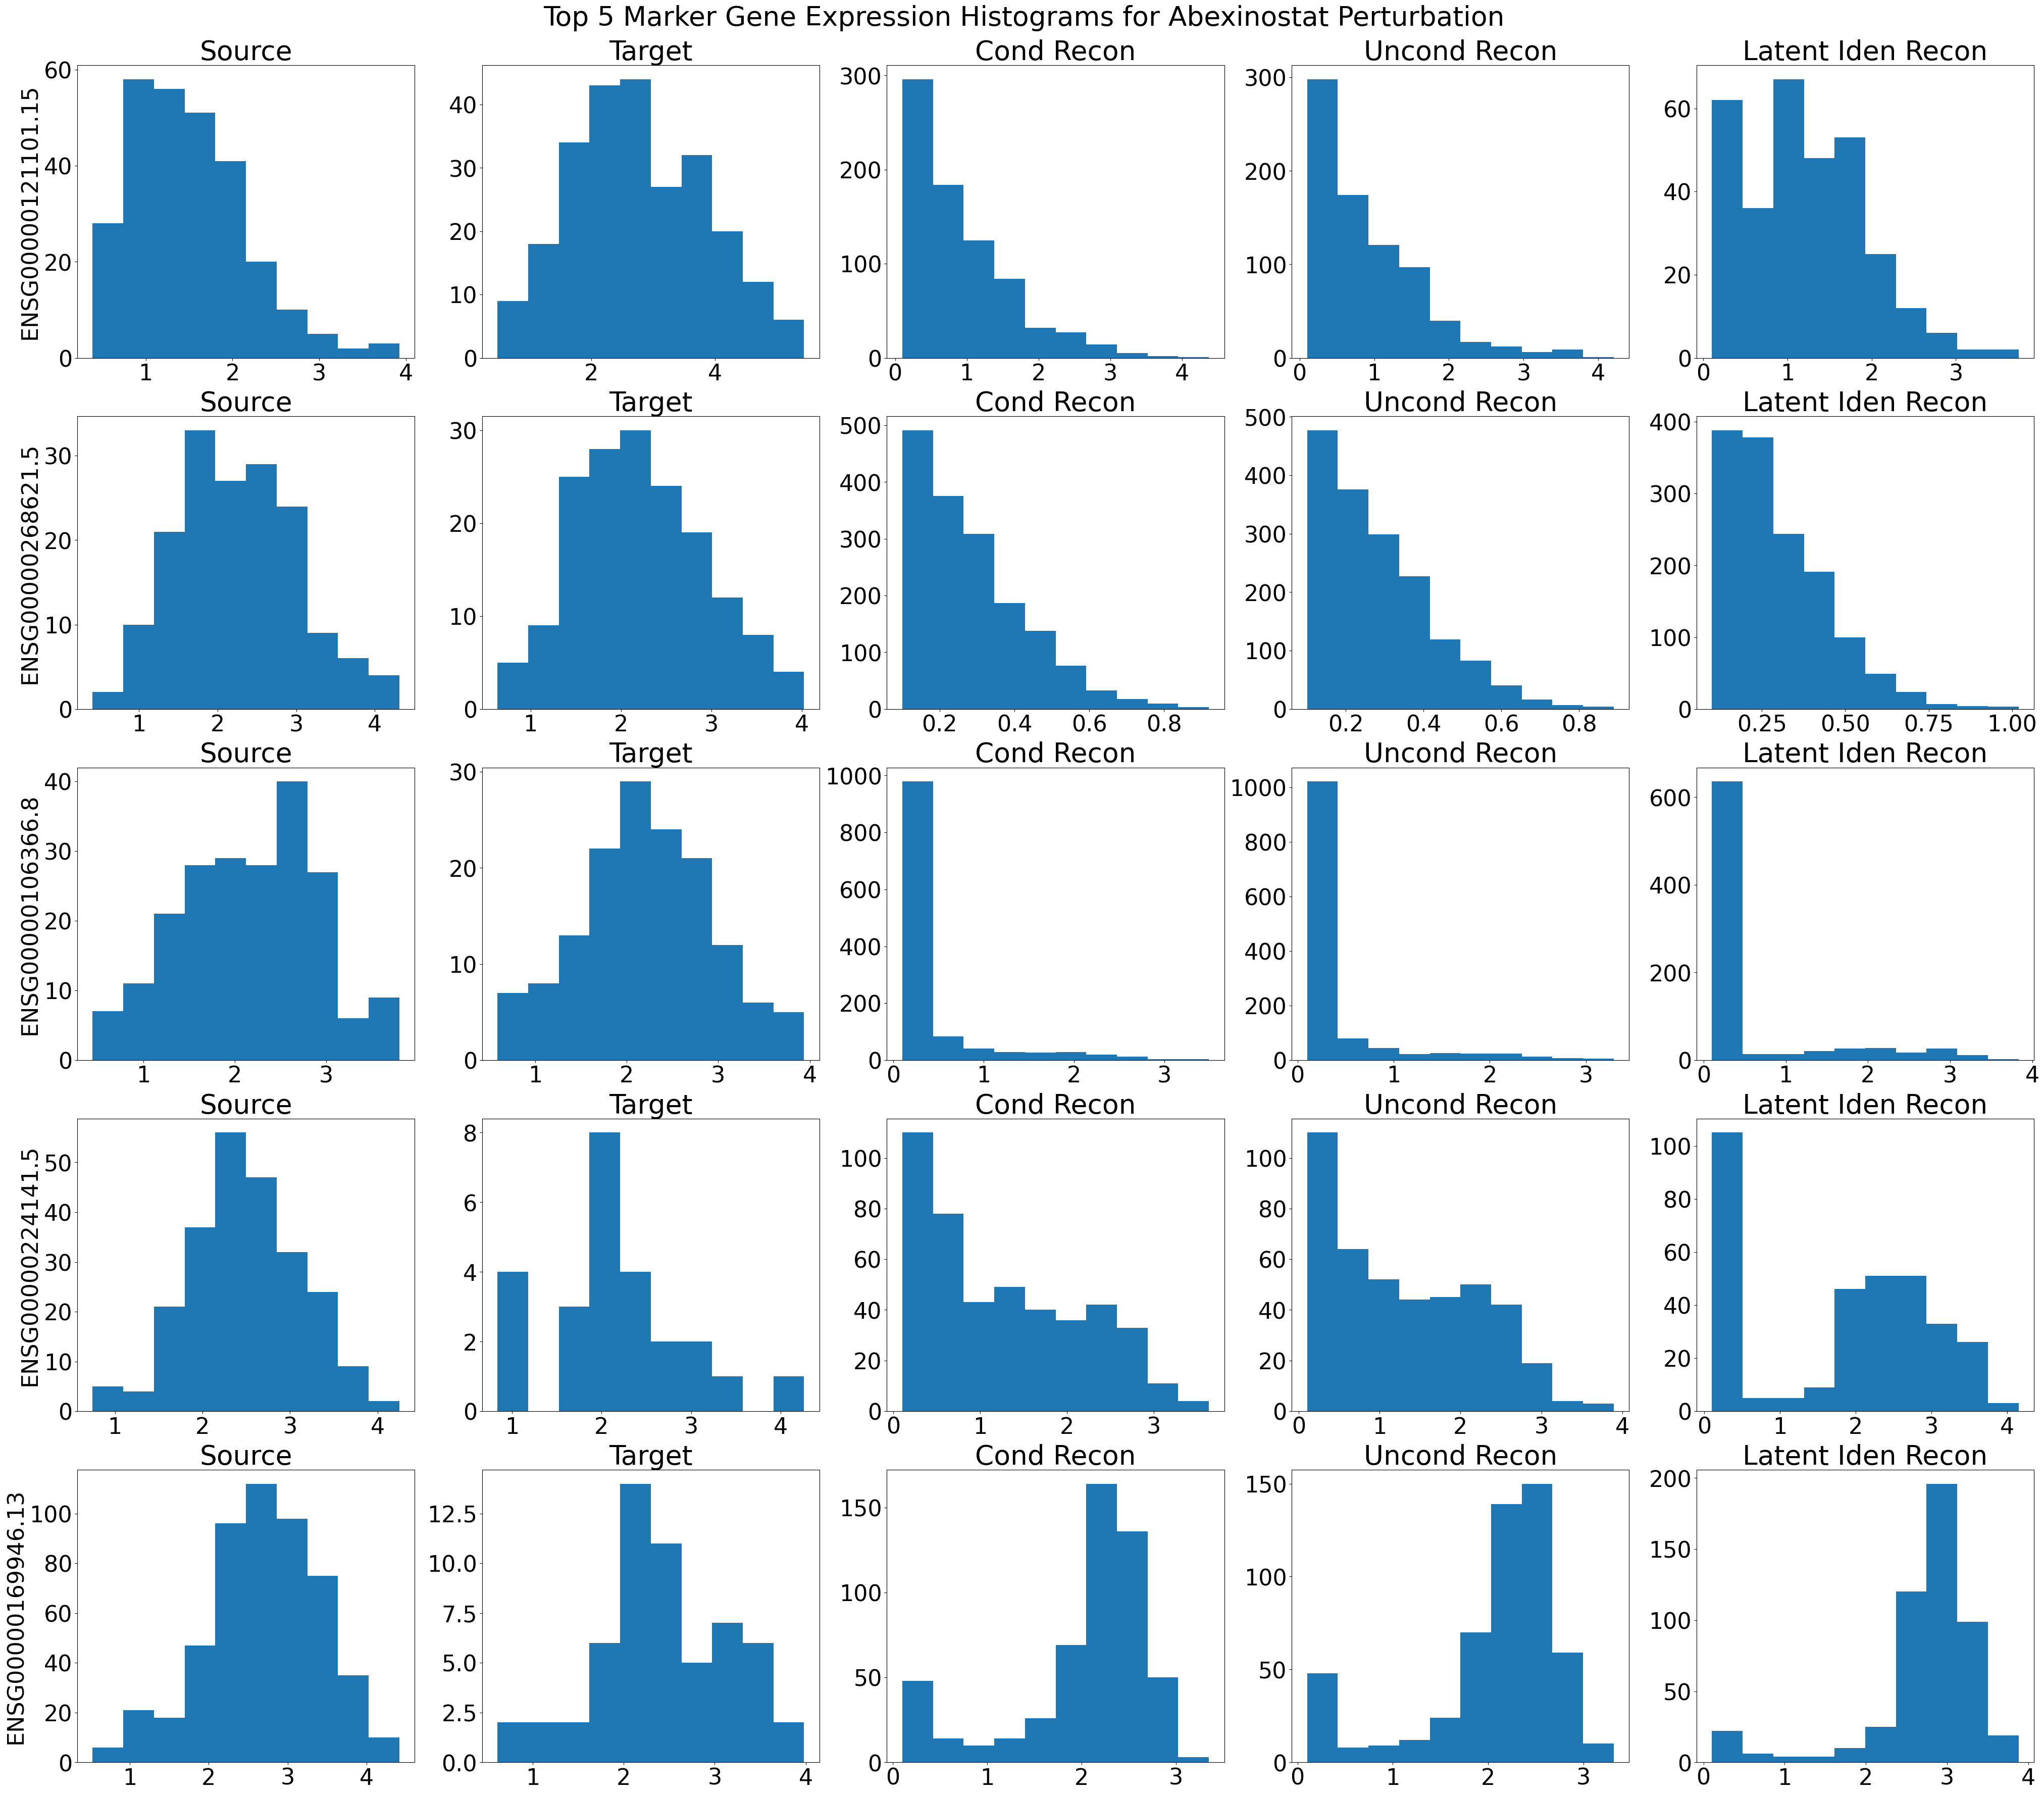

In [30]:
cutoff = 0.1  # Set the value of your cutoff

fig, axs = plt.subplots(5, 5, figsize=(50, 40))
plt.rcParams.update({'font.size': 32})  # Change the number for different font sizes

for i in range(5):
    source_values = all_gts[:, gene_idxs[i]].detach().cpu().numpy()
    target_values = target[:, gene_idxs[i]]
    recon_values = all_recon[:, gene_idxs[i]].detach().cpu().numpy()
    uncond_recon_values = all_uncond_recons[:, gene_idxs[i]].detach().cpu().numpy()
    latent_iden_recon_values = all_latent_identities[:, gene_idxs[i]].detach().cpu().numpy()

    axs[i][0].hist(source_values[source_values > cutoff])
    axs[i][0].set_title('Source')
    
    axs[i][1].hist(target_values[target_values > cutoff])
    axs[i][1].set_title('Target')
    
    axs[i][2].hist(recon_values[recon_values > cutoff])
    axs[i][2].set_title('Cond Recon')
    
    axs[i][3].hist(uncond_recon_values[uncond_recon_values > cutoff])
    axs[i][3].set_title('Uncond Recon')

    axs[i][4].hist(latent_iden_recon_values[latent_iden_recon_values > cutoff])
    axs[i][4].set_title('Latent Iden Recon')

    axs[i][0].set_ylabel(gene_names[i])

fig.subplots_adjust(top=0.95)  # Adjust as needed
fig.suptitle('Top 5 Marker Gene Expression Histograms for Abexinostat Perturbation')

# plt.tight_layout()
plt.show()